In [5]:
import sys
sys.path.append(".")
sys.path.append("..")

In [6]:
from model.my_diffusers.models import AutoencoderKL_Pretrained
from utils.lora_utils.lora import inject_trainable_lora_extended
from warper.so2_warper import SO2_warper
from diffusers import AutoencoderKL, DDIMScheduler, StableDiffusionPipeline

In [7]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as nnf
import numpy as np
import shutil
from torch.optim.adam import Adam
from PIL import Image
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchgeometry as tgm
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
import numpy.typing as npt
from jaxtyping import Float
from torch import Tensor
from pathlib import Path
import json
import random
import os
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from math import log10, sqrt
import copy
import tyro
from dataclasses import dataclass

In [8]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_auth_token=MY_TOKEN, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:115: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to

In [9]:
class DDIM_inversion:
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, 
                                  beta_end=0.012, 
                                  beta_schedule="scaled_linear", 
                                  clip_sample=False,
                                  set_alpha_to_one=False)

        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
        
    @property
    def scheduler(self):
        return self.model.scheduler
    
    
    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    
    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    
    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt
        
        return self.context
    
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred
    
    
    @torch.no_grad()
    def reverse_step(self, latents, prompt_embeds, start_t=0, guidance_scale=7.5):
        start_index = None
        for i, t in enumerate(self.model.scheduler.timesteps):
            if int(t.item()) == int(start_t):
                start_index = i
                break
                
        assert start_index != None
        
        timesteps = self.model.scheduler.timesteps[start_index:]
        for i, t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = self.model.scheduler.scale_model_input(latent_model_input, t)

            noise_pred = self.model.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds
            ).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = self.model.scheduler.step(noise_pred, t, latents).prev_sample
        
        return latents

    
    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = {"0": latent}
        latent = latent.clone().detach()
        
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent[str(t.item())] = latent
            
        return all_latent
    
    
    @torch.no_grad()
    def ddim_invert(self, image):
        latent = self.image2latent(image)
        ddim_latents = self.ddim_loop(latent)
        return ddim_latents
    
    
    def invert(self, image_path: str, prompt: str):
        self.init_prompt(prompt)
        image_gt = load_512(image_path)
        ddim_latents = self.ddim_invert(image_gt)
        
        return image_gt, ddim_latents
    
    
    
ddim_inversion = DDIM_inversion(ldm_stable)

In [10]:
def latent2image(latents, return_type='torch', vae=None):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    if return_type == 'np':
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = (image * 255).astype(np.uint8)

    if return_type == 'torch':
        image = (image / 2 + 0.5).clamp(0, 1)

    return image

def torch_to_pil(img):
    if img.dim() == 4:
        img = img.squeeze(0)
        
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255.0).astype(np.uint8)
    img = Image.fromarray(img)
    
    return img

def mse(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    return mse

def mse_psnr(original, predicted):
    mse_val = mse(original, predicted)
    if(mse_val == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse_val))
    return mse_val, psnr

def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

def sub_vec(A, B):
    return np.linalg.norm(A - B) / np.linalg.norm(A)

In [11]:
ckpt_path = "/home/jh27kim/warp_latent/ckpt/dec_lora_ep_9.pt"
state_dict = torch.load(ckpt_path)

In [12]:
class VAE_lora_dec(SO2_warper):
    def __init__(self) -> None:
        self.device = device
        self.autoencoder_pretrained = AutoencoderKL_Pretrained.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(self.device)

        self.target_replace_module = {"UNetMidBlock2D", "UpDecoderBlock2D"}
        self.lora_params, train_names = inject_trainable_lora_extended(self.autoencoder_pretrained.decoder, target_replace_module=self.target_replace_module, verbose=False)
        
        self.raw_vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
        self.raw_vae.to(self.device)


    def latent2image(self, src_latent):
        # NOTE: Image should be normalized -1 1
        src_latent = 1 / self.autoencoder_pretrained.config.scaling_factor * src_latent

        imgs = self.autoencoder_pretrained.decode(src_latent).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs
    
    def image2latent(self, img):
        # imgs: [B, 3, H, W]
        img = 2 * img - 1

        posterior = self.autoencoder_pretrained.encode(img).latent_dist
        latents = posterior.sample() * self.autoencoder_pretrained.config.scaling_factor

        return latents
    
    def raw_latent2image(self, latent):
        latent = 1 / self.raw_vae.config.scaling_factor * latent
        img = self.raw_vae.decode(latent).sample
        img = (img / 2 + 0.5).clamp(0, 1)
        return img
    
lora_dec = VAE_lora_dec()
lora_dec.autoencoder_pretrained.decoder.load_state_dict(state_dict["decoder_lora"])
print("Loaded LoRA decoder")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loaded LoRA decoder


In [13]:
image_path = "/home/jh27kim/warp_latent/dataset/afhq/val/dog/image"
image_path = [os.path.join(image_path, i) for i in os.listdir(image_path)]
print(image_path[0], len(image_path))

/home/jh27kim/warp_latent/dataset/afhq/val/dog/image/flickr_dog_000823.jpg 500


In [88]:
guidance_scale=1.0
prompt = "dog"
text_embeddings = ddim_inversion.init_prompt(prompt)
start_t = scheduler.timesteps[-1]
diffusion_iteration=5
print(scheduler.timesteps, scheduler.timesteps.shape, start_t, "diffusion_iteration", diffusion_iteration)

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1]) torch.Size([50]) tensor(1) diffusion_iteration 5


In [89]:
# Comparison in image space

scale = torch.ones(1)

PSNR_finetune = []
PSNR_raw = []

SSIM_finetune = []
SSIM_raw = []

MSE_finetune = []
MSE_raw = []

with torch.no_grad():
    for i, img_path in enumerate(image_path):
        src_img = Image.open(img_path).convert('RGB')
        init_width, init_height = src_img.size
        if init_width != 512 or init_height != 512:
            src_img = src_img.resize((512, 512))
        src_img = (np.array(src_img) / 255.0).astype(np.float32)
        src_img = torch.tensor(src_img).permute(2, 0, 1).unsqueeze(0).to(device)
        
        src_latent = lora_dec.image2latent(src_img)
        angle = (torch.rand(1) - 0.5) * 2 # -1 ~ 1
        angle *= 180.0
        
        latent_center = torch.ones(1, 2)
        latent_center[..., 0] = src_latent.shape[3] / 2  # x
        latent_center[..., 1] = src_latent.shape[2] / 2  # y
        
        # Latent warp
        _, _, latent_h, latent_w = src_latent.shape
        latent_SO2 = lora_dec.get_rotation_matrix2d(latent_center.to(src_img), angle.to(src_img), scale.to(src_img))
        SO2_warp_latent = lora_dec.warp_affine(src_latent, 
                                latent_SO2, 
                                dsize=(latent_h, latent_w), 
                                interpolation_mode="bilinear", 
                                padding_mode="reflection")
        
        res_raw = lora_dec.raw_latent2image(SO2_warp_latent)
        
        # Apply further refinement using Diffusion Model
        diff_warp_latent = copy.deepcopy(SO2_warp_latent)
        for j in range(diffusion_iteration):
            noise = torch.randn_like(SO2_warp_latent).to(diff_warp_latent) # Random noise
            noisy_SO2_warp_latent = scheduler.add_noise(diff_warp_latent,
                                                        noise,
                                                        start_t)

            diff_warp_latent = ddim_inversion.reverse_step(noisy_SO2_warp_latent, 
                                                                  prompt_embeds=text_embeddings,
                                                                  start_t=start_t,
                                                                  guidance_scale=guidance_scale)
        refined_SO2_warp_latent = copy.deepcopy(diff_warp_latent)

        res_diffusion_refined = lora_dec.latent2image(refined_SO2_warp_latent)
        res_finetune = lora_dec.latent2image(SO2_warp_latent)

        
        
        # Image warp
        img_center = torch.ones(1, 2)
        img_center[..., 0] = src_img.shape[3] / 2  # x
        img_center[..., 1] = src_img.shape[2] / 2  # y
        img_SO2 = lora_dec.get_rotation_matrix2d(img_center.to(src_img), angle.to(src_img), scale.to(src_img)) 
        _, _, img_h, img_w = src_img.shape

        tar_img = lora_dec.warp_affine(src_img, 
                              img_SO2, 
                              dsize=(img_h, img_w), 
                              interpolation_mode="bilinear", 
                              padding_mode="reflection")
        
        res_finetune_numpy = np.array(torch_to_pil(res_finetune))
        res_raw_numpy = np.array(torch_to_pil(res_raw))
        res_target_numpy = np.array(torch_to_pil(tar_img))
        
        mse_raw, psnr_raw = mse_psnr(res_target_numpy, res_raw_numpy)
        mse_finetune, psnr_finetune = mse_psnr(res_target_numpy, res_finetune_numpy)
        
        SSIM_finetune.append(ssim(res_target_numpy, res_finetune_numpy, channel_axis=-1))
        SSIM_raw.append(ssim(res_target_numpy, res_raw_numpy, channel_axis=-1))
        
        PSNR_finetune.append(psnr_finetune)
        PSNR_raw.append(psnr_raw)
    
        MSE_finetune.append(mse_finetune)
        MSE_raw.append(mse_raw)
        
        print(f"{i+1} / {len(image_path)}")
        
        # NOTE: Debugging purpose
        if i == 0: break


1 / 500


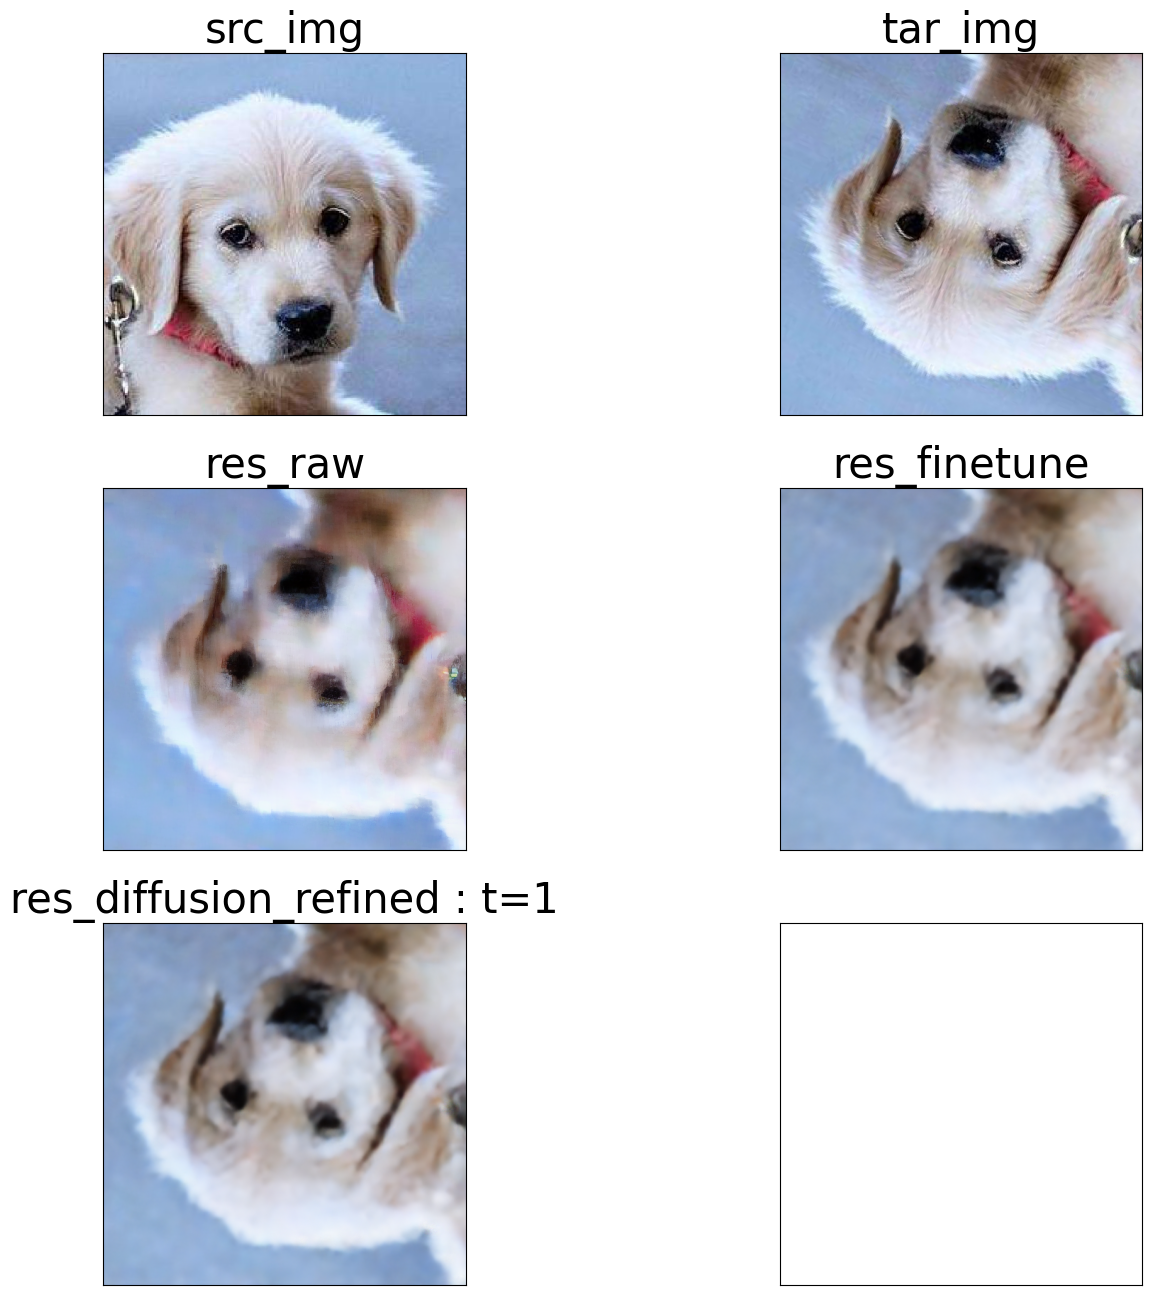

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
dummy_img = torch.ones((1, 3, 512, 512))
plot_img = [src_img, tar_img, res_raw, res_finetune, res_diffusion_refined, dummy_img]
plot_title = ["src_img", "tar_img", "res_raw", "res_finetune", f"res_diffusion_refined : t={start_t}", ""]

for i, ax in enumerate(axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_title[i], fontsize=30)
    ax.imshow(torch_to_pil(plot_img[i]))


In [ ]:
compute_mean = lambda x: np.mean(np.array(x))
for arr in [MSE_raw, MSE_finetune, PSNR_raw, PSNR_finetune, SSIM_raw, SSIM_finetune]:
    print(compute_mean(arr))